# Integrantes

Martín Vazquez Arispe mvazquezarispe@alumnos.exa.unicen.edu.ar

David Burckhardt dburckhardt@alumnos.exa.unicen.edu.ar

# Enunciado

Dados los siguientes dataset utilizados en los prácticos 2.a y 2.b:

Palmer Penguins Dataset (OpenML id 43347 : https://www.openml.org/d/43347/)

Spam en mensajes de texto (adjunto, versión en jsons)


Resolver para cada dataset los siguiente puntos:


a. Definir cuál es el objetivo de aplicar técnicas de clasificación.

b. En caso de ser necesario, definir qué pre‐procesamiento se realizará a los datos. Justificar.

d. Obtener dos clasificadores utilizando la librería Scikit learn. Para ello elegir 2 técnicas de clasificación, configurar los clasificadores, y ejecutar los algoritmos. Justificar las decisiones tomadas.

e. Evaluar los dos clasificadores y compararlos, indicando cual de los dos recomendaría.

f. Explicar un ejemplo de cómo los clasificadores obtenidos pueden ser usados en el futuro en una aplicación real.

## Consigna: A

*Definir cuál es el objetivo de aplicar técnicas de clasificación*

Las técnicas de clasificación tienen como objetivo asignar una etiqueta o categoría a nuevas observaciones basándose en un conjunto de datos previamente etiquetado. Estos métodos aprenden patrones o relaciones entre los datos de entrada y la variable objetivo para luego poder realizar predicciones automáticas sobre datos no vistos.

El objetivo de aplicar técnicas de clasificación en este dataset es predecir si un texto es spam o no.

## Consigna: B

*En caso de ser necesario, definir qué pre‐procesamiento se realizará a los datos. Justificar.*

Monta Google Drive, copia el archivo ZIP con los datos al entorno local y lo descomprime.

In [ ]:
from google.colab import drive
import pandas as pd
# Montamos la unidad de Google Drive (solicitará autorización)
drive.mount('/content/gdrive', force_remount=True)

# Copia el zip al entorno de ejecución y los descomprime
zip_path = "/content/gdrive/My Drive/Diplomatura IA/Modulo 1/jsons-spam.zip"
!cp "{zip_path}" .
!unzip -q jsons-spam.zip

Mounted at /content/gdrive


Busca los archivos JSON para extraer textos y etiquetas, y los guarda en listas separadas para análisis de mensajes y clasificación.

In [ ]:
import glob # El modulo glob permite buscar todos los pathnames que machean con un patrón espécifico de acuerdo a las reglas de la shell de UNIX
import json

# Busca los archivos json en el directorio jsons-spam
file_path = glob.glob("/content/jsons-spam/*.json")
X = []
y = []

# Lee cada archivo y carga la información en las listas X e y
for file in file_path:
    with open(file, 'r') as j:
      json_data = json.load(j) # Carga el json
    X.append(json_data['v2'])
    y.append(json_data['v1'])

print(f"Cantidad de corpus: {len(X)}")
print(f"Cantidad de labels: {len(y)}")

Cantidad de corpus: 5572
Cantidad de labels: 5572


### Pasos

1. Tokenización: Separa el texto en palabras individuales, permitiendo su análisis estadístico o lingüístico posterior de forma estructurada.

2. Eliminación de stop-words: Elimina palabras frecuentes sin significado útil, como "el", "de", "y", que no aportan al análisis del contenido.

3. Stemming: Reduce palabras a su raíz común, agrupando variantes como "corriendo", "corre", "corrió" en una sola forma base.

4. Filtrado por mínima frecuencia: Elimina términos raros que aparecen en pocos documentos y que generalmente no son relevantes para el análisis general.

5. Transformación TF-IDF: Se calcula el peso de cada término en el corpus con TfidfTransformer, priorizando términos relevantes y penalizando los más comunes.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from nltk.stem import PorterStemmer

# Inicializamos el stemmer
stemmer = PorterStemmer()

# Base analyzer con stopwords en inglés
base_analyzer = CountVectorizer(stop_words='english').build_analyzer()

# Función de análisis personalizada
def stemmed_words(doc):
    return (stemmer.stem(w) for w in base_analyzer(doc))

# Pipeline de preprocesamiento
text_preprocessing_pipeline = Pipeline([
    ('vect', CountVectorizer(analyzer=stemmed_words, min_df=2)),
    ('tfidf', TfidfTransformer())
])

### Prueba del preprocesamiento

Como parte del proceso de exploración y evaluación del preprocesamiento de texto, se analizaron tres métricas fundamentales derivadas del uso de un vectorizador con stemming y eliminación de stopwords: vocabulario total (vocab), número total de palabras (words) y cantidad de hapax legomena (hapax). A continuación se detallan los resultados obtenidos:

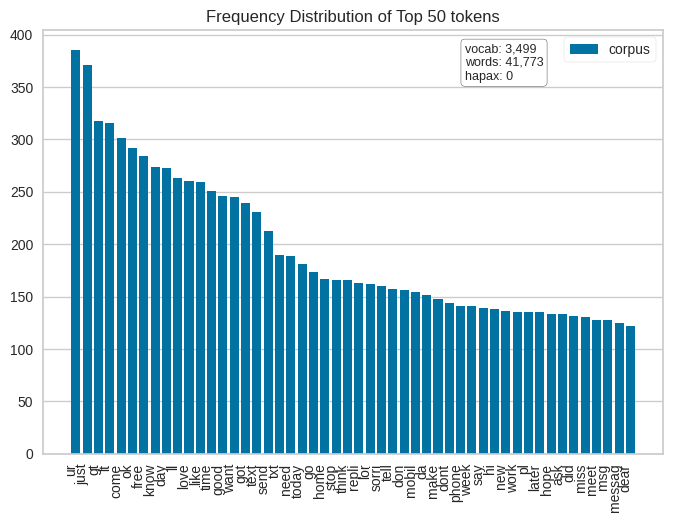

<Axes: title={'center': 'Frequency Distribution of Top 50 tokens'}>

In [ ]:
from yellowbrick.text import FreqDistVisualizer
import numpy as np

# 4. Ajustamos pipeline y obtenemos solo la etapa de CountVectorizer
text_preprocessing_pipeline.fit(X)

# Extraemos la etapa de vect
vect = text_preprocessing_pipeline.named_steps['vect']
X_counts = vect.transform(X)

# 5. Visualización de frecuencias
features = vect.get_feature_names_out()
visualizer = FreqDistVisualizer(features=features, orient='v')
visualizer.fit(X_counts)
visualizer.show()

#### Resultado

Los resultados obtenidos fueron los siguientes:

- *Vocabulario total (vocab):* El vocabulario total fue de 3.499 palabras únicas tras aplicar stopwords y stemming. Representa la cantidad de términos distintos considerados relevantes para el modelo de análisis de texto.
- *Número total de palabras (words):* Se contabilizaron 41.773 palabras en total, incluyendo repeticiones. Esta cifra refleja la densidad léxica del corpus y permite dimensionar la cantidad de texto efectivamente procesado por el vectorizador.
- Hapax legomena (hapax): El valor de hapax fue 0, ya que se utilizó `min_df=2`. Esto significa que se excluyeron todas las palabras que aparecen solo una vez, reduciendo ruido y términos poco informativos.

## Consigna: D

*Obtener dos clasificadores utilizando la librería Scikit learn. Para ello elegir 2 técnicas de clasificación, configurar los clasificadores, y ejecutar los algoritmos. Justificar las decisiones tomadas.*

Se utilizó una partición estratificada para asegurar que la proporción de cada clase en el conjunto de entrenamiento y test sea representativa del dataset original. Esto es especialmente importante en problemas de clasificación para evitar sesgos y garantizar que el modelo aprenda y se evalúe correctamente sobre todas las clases presentes, manteniendo la distribución balanceada de spams en ambos subconjuntos. Se eligió un test_size=0.2 para reservar el 20% del dataset como conjunto de prueba, lo cual es adecuado cuando se dispone de una cantidad limitada de muestras.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### SVM

SVM funciona muy bien con alta dimensionalidad, como ocurre con datos TF-IDF donde hay miles de características (palabras). Con el kernel lineal suele obtener muy buen rendimiento en problemas de clasificación de texto (como spam detection, análisis de sentimiento, etc).

In [ ]:
from sklearn.svm import SVC

# Crea el pipeline
pipe = make_pipeline(
     text_preprocessing_pipeline,
     SVC()
 )

# Evalua el modelo con distintas métricas
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'precision_weighted', 'recall_weighted']
scores_svc = cross_validate(pipe, X_train, y_train, scoring=scoring, cv=5)

print(f"Accuracy: {scores_svc['test_accuracy'].mean():.2f}")
print(f"Precision macro: {scores_svc['test_precision_macro'].mean():.2f}")
print(f"Recall macro: {scores_svc['test_recall_macro'].mean():.2f}")
print(f"Precision weighted: {scores_svc['test_precision_weighted'].mean():.2f}")
print(f"Recall weighted: {scores_svc['test_recall_weighted'].mean():.2f}")


Accuracy: 0.98
Precision macro: 0.99
Recall macro: 0.94
Precision weighted: 0.98
Recall weighted: 0.98


### Naive Bayes

Es muy rápido y eficiente para datos textuales. A pesar de su simplicidad y suposiciones fuertes (independencia entre palabras), tiene un rendimiento sorprendentemente bueno con TF-IDF o conteo de palabras.

In [ ]:
from sklearn.naive_bayes import MultinomialNB

# Crea el pipeline
pipe = make_pipeline(
     text_preprocessing_pipeline,
     MultinomialNB()
 )

# Evalua el modelo con distintas métricas
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'precision_weighted', 'recall_weighted']
scores_nb = cross_validate(pipe, X_train, y_train, scoring=scoring, cv=5)

print(f"Accuracy: {scores_nb['test_accuracy'].mean():.2f}")
print(f"Precision macro: {scores_nb['test_precision_macro'].mean():.2f}")
print(f"Recall macro: {scores_nb['test_recall_macro'].mean():.2f}")
print(f"Precision weighted: {scores_nb['test_precision_weighted'].mean():.2f}")
print(f"Recall weighted: {scores_nb['test_recall_weighted'].mean():.2f}")


Accuracy: 0.98
Precision macro: 0.99
Recall macro: 0.91
Precision weighted: 0.98
Recall weighted: 0.98


No se utilizaron los algoritmos KNN ni Decision Tree debido a que ambos presentan limitaciones importantes en contextos de clasificación de texto con representaciones TF-IDF. KNN, al basarse en distancias en espacios vectoriales, se ve fuertemente afectado por la alta dimensionalidad del texto, volviéndose computacionalmente costoso y menos preciso. Por su parte, Decision Tree tiende a sobreajustarse cuando se enfrenta a un gran número de características, como ocurre en modelos de texto, lo que compromete su capacidad de generalización.

#### Gráficos Comparativos

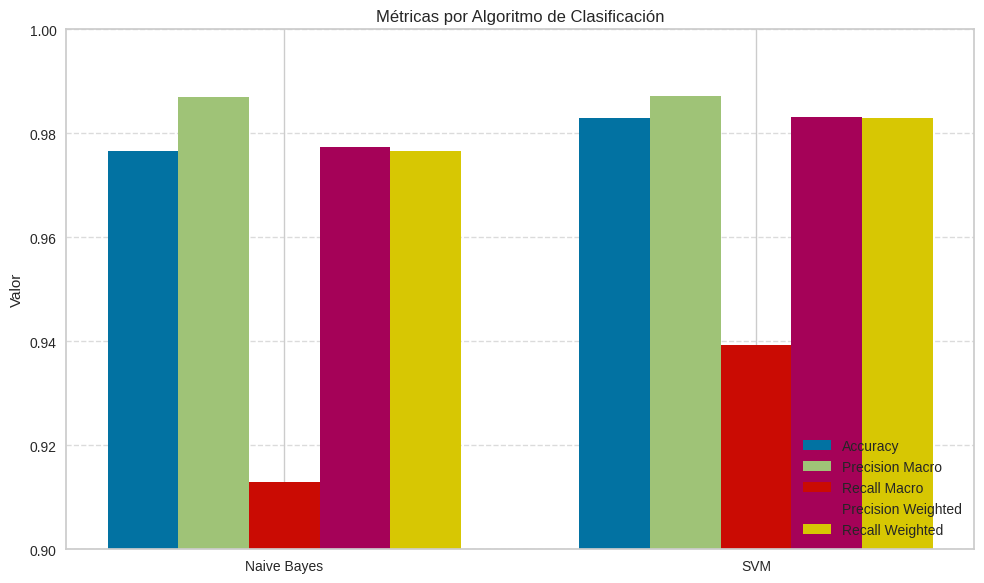

In [ ]:
import matplotlib.pyplot as plt

# Modelos
modelos = ['Naive Bayes', 'SVM']

# Métricas
accuracy = [scores_nb['test_accuracy'].mean(), scores_svc['test_accuracy'].mean()]
precision_m = [scores_nb['test_precision_macro'].mean(), scores_svc['test_precision_macro'].mean()]
recall_m = [scores_nb['test_recall_macro'].mean(), scores_svc['test_recall_macro'].mean()]
precision_w = [scores_nb['test_precision_weighted'].mean(), scores_svc['test_precision_weighted'].mean()]
recall_w = [scores_nb['test_recall_weighted'].mean(), scores_svc['test_recall_weighted'].mean()]

# Posiciones
x = np.arange(len(modelos))
width = 0.15  # ancho de las barras

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - 2*width, accuracy, width, label='Accuracy')
ax.bar(x - width, precision_m, width, label='Precision Macro')
ax.bar(x, recall_m, width, label='Recall Macro')
ax.bar(x + width, precision_w, width, label='Precision Weighted')
ax.bar(x + 2*width, recall_w, width, label='Recall Weighted')

# Etiquetas y título
ax.set_ylabel('Valor')
ax.set_title('Métricas por Algoritmo de Clasificación')
ax.set_xticks(x)
ax.set_xticklabels(modelos)
ax.legend(loc='lower right')

plt.ylim(0.9, 1)  # Puedes ajustarlo según tus datos
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Consigna E

*Evaluar los dos clasificadores y compararlos, indicando cual de los dos recomendaría.*

Ambos modelos tienen un Accuracy igual (0.98) y Precision macro y weighted muy similares (0.99 y 0.98). Sin embargo, hay una diferencia clave, SVM tiene un Recall macro de 0.94, mientras que Naive Bayes tiene 0.91. SVM es ligeramente mejor debido a su mayor recall macro, lo cual indica que generaliza mejor en todas las clases, especialmente en aquellas con menos ejemplos o más complejas.

#### Entrenamiento completo con SVM

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Entrenar modelo final con todo el set de entrenamiento
pipe = make_pipeline(
     text_preprocessing_pipeline,
     SVC()
 )

pipe.fit(X_train, y_train)

# Evaluar en el set de prueba
y_pred_svm = pipe.predict(X_test)

# Métricas
def obtener_metricas(y_true, y_pred):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision_macro": precision_score(y_true, y_pred, average='macro'),
        "recall_macro": recall_score(y_true, y_pred, average='macro'),
        "f1_macro": f1_score(y_true, y_pred, average='macro')
    }

metricas_svm = obtener_metricas(y_test, y_pred_svm)

print("Métricas para SVM:")
print(metricas_svm)

## Consigna F

*Explicar un ejemplo de cómo los clasificadores obtenidos pueden ser usados en el futuro en una aplicación real.*

Un posible dominio de uso del clasificador es en plataformas de mensajería o foros en línea, donde puede identificar y filtrar mensajes no deseados (spam), como publicidad automatizada o enlaces repetitivos enviados por bots. Este sistema ayuda a mantener conversaciones limpias y relevantes, mejorando la experiencia del usuario. También puede ser útil en aplicaciones como Discord, Telegram o foros educativos, marcando mensajes sospechosos para revisión o bloqueándolos automáticamente antes de que se publiquen.